## First Foraging Model
Parameter: Age, Indicator of frame, Mean distance from Exit in past 10 mins <br>
Assumption: All leaving bees are assumed to be foraging

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
from bees_lifetimetracking_2018data import datafunctions
from bees_lifetimetracking_2018data import definitions_2018 as bd
from bees_lifetimetracking_2018data import displayfunctions as bp

datafunctions.init(bd) 
bp.init(bd)

warnings.filterwarnings("ignore")

/Users/padmaprabagaran/dev/honey-bee-behavior/bees_lifetimetracking_2018data/definitions_2018.py:20: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  cohort_birthdates = np.array([pd.Timestamp(np.array(cohort_data['DOB'][cohort_data['cohort']==c])[0],freq='D') for c in cohort_colornames])


### Get the Data

In [2]:
PATH = '/Users/padmaprabagaran/dev/honey-bee-behavior/Data/zenodo/'

In [12]:
def getExitFrameLocation(df):
    x_max = 6500
    x_min = 3500
    y_min = 3800
    y_max = 5400
    
    x = np.array(df['x']).astype(float)
    y = np.array(df['y']).astype(float)
    camera = np.array(df['camera']).astype(int)
    conv_factor = 1
    x_adjusted = x/conv_factor + (np.logical_not(camera).astype(int))*bd.xpixels
    y_adjusted = y/conv_factor

    
    x_bounds = (x_adjusted >= x_min) & (x_adjusted <= x_max)
    y_bounds = (y_adjusted >= y_min) & (y_adjusted <= y_max)
    
    df['in_exit_frame'] = (x_bounds & y_bounds).astype('int')
    
    return df

In [30]:
def getMeanExitDist():

SyntaxError: unexpected EOF while parsing (3657728501.py, line 1)

In [26]:
def getData(daynum,df):
    if daynum >= 50:
        datadir = PATH + 'beetrajectories_days_050_to_085/'
    else:
        datadir = PATH + 'beetrajectories_days_000_to_049/'

    temp = pd.read_hdf('{}beetrajectories_{:0>3}.hdf'.format(datadir,daynum))

    ### DID THE BEE LEAVE?
    dataDir = PATH + 'df_day1min_alldays/'
    dfday = pd.read_hdf('{}df_day1min_{:0>2}.hdf'.format(dataDir,daynum))
    numtimedivs = len(dfday['timedivision'].unique()) # minutes in a day
    day_uids, day_ages, all_inhive, bee_obs, bee_exitdist = datafunctions.get_inout_estimates(dfday,
                                                                                              numtimedivs=numtimedivs)

    leave_hive_times_list = [np.where(diffs==-1)[0] for diffs in np.diff(all_inhive) ]

    leave_hive_times_by_uid = []

    for uid,leave_hive_times in zip(day_uids,leave_hive_times_list):
        for leave_hive_time in leave_hive_times:
            leave_hive_times_by_uid.append([uid,leave_hive_time])
    df_leave_hive_events = pd.DataFrame(leave_hive_times_by_uid,columns=['uid','leave hive time'])

    frames_per_day = 24*60*60*3
    frames_per_timedivision = frames_per_day / numtimedivs
    df_leave_hive_events['leave hive framenum'] = df_leave_hive_events['leave hive time']*frames_per_timedivision

    leave_hive_times_by_uid = []
    for uid,leave_hive_times in zip(day_uids,leave_hive_times_list):
        for leave_hive_time in leave_hive_times:
            leave_hive_times_by_uid.append([uid,leave_hive_time])
    df_leave_hive_events = pd.DataFrame(leave_hive_times_by_uid,columns=['uid','leave hive time'])

    # translate time to framenum (assuming 3 frames per second)
    frames_per_day = 24*60*60*3
    frames_per_timedivision = frames_per_day / numtimedivs
    df_leave_hive_events['leave hive framenum'] = (df_leave_hive_events['leave hive time']*frames_per_timedivision).astype('int')


    temp['forage'] = np.where((temp['framenum'].isin(df_leave_hive_events['leave hive framenum']))&(temp['uid'].isin(df_leave_hive_events['uid'])), 1,0)

    
    ### AGE

    age_id = dfday[['Age','Bee unique ID']].astype('int')
    age_id = age_id.rename(columns={"Bee unique ID":'uid'})
    age_id = age_id.drop_duplicates()

    temp = pd.merge(temp,age_id,on='uid', how='left')

    ### Indicator of frame

    temp = getExitFrameLocation(temp)

    
    ### Mean Exit Diastance
    
    
    df = df.append(temp)
    
    return df
    

In [27]:
df = pd.DataFrame()
for x in range(25,31):
   df = getData(x,df)

In [28]:
df

,daynum,framenum,uid,x,y,camera,theta,forage,Age,in_exit_frame
0,25,4794,1008,1055,3575,0,-1.20026,0,30,0
1,25,4797,1008,1046,3567,0,-1.57628,0,30,0
2,25,4798,1008,1022,3543,0,-1.80941,0,30,0
3,25,4799,1008,1022,3535,0,-1.65249,0,30,0
4,25,4800,1008,1022,3535,0,-1.35657,0,30,0
...,...,...,...,...,...,...,...,...,...,...
16092213,30,255198,4095,1727,528,0,1.74897,0,0,0
16092214,30,255199,4095,1728,536,0,1.59894,0,0,0
16092215,30,255200,4095,1736,536,0,1.55098,0,0,0
16092216,30,255201,4095,1727,544,0,1.67417,0,0,0


## Model Building

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
def model_performance(model,x_train,x_test, y_train,y_test):
    print(f"{model} Performance:\n")
    
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    sns.set(rc = {'figure.figsize':(6,4)})
    sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
    yticklabels = ['No Forage', 'Forage'], xticklabels = ['Predicted no forage', 'Predicted forage'])
    plt.show()
   
    
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)

    cross_val_score_insample = cross_val_score(model,x_train,y_train,cv=5,scoring='accuracy').mean()
    cross_val_score_outsample = cross_val_score(model,x_test,y_test,cv=5,scoring='accuracy').mean()
    
    print('Precision Score:',precision)
    print("Recall Score:",recall)
    print("Accuracy Score:",accuracy)
    print('F1 Score:',f1)
    print("Cross Val Score Insample",cross_val_score_insample)
    print("Cross Val Score Outsample",cross_val_score_outsample)
    
    return model,precision,recall,accuracy,cross_val_score_insample,cross_val_score_outsample

### Balance the data set

In [39]:
df.forage.value_counts()

0    98183381
1       52723
Name: forage, dtype: int64

In [40]:
## BALANCE THE DATA
df_bal= df.groupby('forage').apply(lambda grp: grp.sample(n=50000)).reset_index(level=[0, 1], drop=True)

In [41]:
df_bal.forage.value_counts()

0    50000
1    50000
Name: forage, dtype: int64

### Split into train and test

In [42]:
from sklearn.model_selection import train_test_split

y = df_bal['forage']
X = df_bal[['Age','in_exit_frame']]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=25)

### Naive Bayes

GaussianNB() Performance:



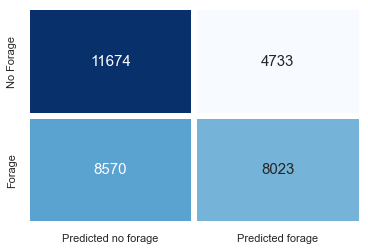

Precision Score: 0.6289589212919411
Recall Score: 0.4835171457843669
Accuracy Score: 0.5968787878787879
F1 Score: 0.546730723363658
Cross Val Score Insample 0.6016119402985074
Cross Val Score Outsample 0.5968787878787879


In [43]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

performance_nb = model_performance(gnb, X_train, X_test, y_train, y_test)

### KNN

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn_temp_model = KNeighborsClassifier()
param_grid={'weights' : ['uniform','distance'],'n_neighbors' : (np.arange(9)+2)}
knn_grid = GridSearchCV(knn_temp_model,param_grid,cv=5,scoring='accuracy',verbose=1)
grid_results = knn_grid.fit(X_train,y_train)
best_k = knn_grid.best_params_['n_neighbors']
print("\t Ideal K-Val: {}".format(best_k))
print("\t Accuracy of Tuned Training Data: {:.2f}%".format(grid_results.best_score_ * 100))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
	 Ideal K-Val: 9
	 Accuracy of Tuned Training Data: 59.39%


KNeighborsClassifier(n_neighbors=9) Performance:



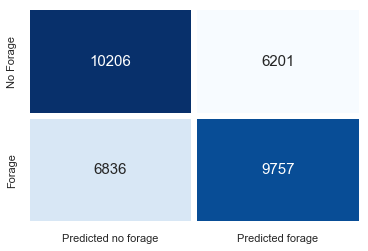

Precision Score: 0.6114174708610102
Recall Score: 0.5880190441752546
Accuracy Score: 0.6049393939393939
F1 Score: 0.5994900310282327
Cross Val Score Insample 0.5938955223880598
Cross Val Score Outsample 0.5837878787878787


In [47]:
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train, y_train)
performance_knn = model_performance(knn_model,X_train, X_test, y_train, y_test)

### Logistic Regression
    

Number of mislabeled points out of a total 33000 points : 13400
LogisticRegression() Performance:



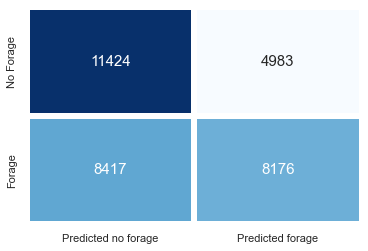

Precision Score: 0.6213238088000608
Recall Score: 0.49273790152473934
Accuracy Score: 0.593939393939394
F1 Score: 0.5496101102446894
Cross Val Score Insample 0.5986268656716417
Cross Val Score Outsample 0.5923939393939394


In [49]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=100)
y_pred = lr.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
performance_lr = model_performance(lr,X_train, X_test, y_train, y_test)

### Random Forest

Number of mislabeled points out of a total 33000 points : 12563
RandomForestClassifier() Performance:



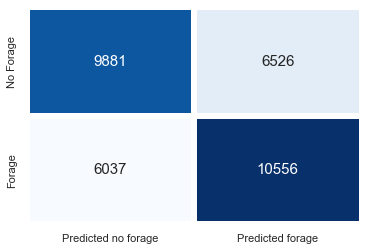

Precision Score: 0.6179604261796042
Recall Score: 0.6361718797083107
Accuracy Score: 0.6193030303030304
F1 Score: 0.6269339272457313
Cross Val Score Insample 0.6255074626865672
Cross Val Score Outsample 0.6204242424242425


In [51]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
y_pred = rfc.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
performance_rfc = model_performance(rfc,X_train, X_test, y_train, y_test)

### SVM

Number of mislabeled points out of a total 33000 points : 13878
SVC(kernel='linear') Performance:



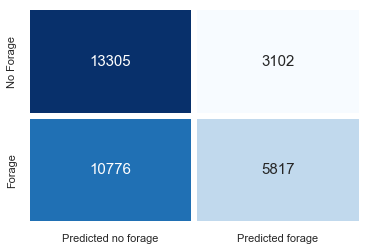

Precision Score: 0.6522031617894383
Recall Score: 0.35056951726631713
Accuracy Score: 0.5794545454545454
F1 Score: 0.45602069614299157
Cross Val Score Insample 0.5831791044776119
Cross Val Score Outsample 0.5794545454545454


In [52]:
from sklearn.svm import SVC

svm = SVC(kernel = 'linear')
y_pred = svm.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
performance_svm = model_performance(svm,X_train, X_test, y_train, y_test)